# Librerias

In [13]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import tensorflow as tf
import keras_tuner
from nltk.probability import FreqDist
from funciones import build_optimizer, get_sent_tokens,get_lemma,get_stems,remove_stop_words,get_word_tokens, remove_special_characters, tokenize_summary, filter_and_tokenize_words, get_word_counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution,LogUniformDistribution
from keras.preprocessing import sequence
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, pad_sequences




# Obtención y preprocesado de datos

In [14]:
data = pd.read_csv("../data/BooksDataSet.csv").drop(columns=['Unnamed: 0'])
data

,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...,...,...
2995,10372180,White Death,Thriller,"A Novel from the NUMA files, A Kurt Austin Ad..."
2996,14504372,Venus with Pistol,Thriller,Gilbert Kemp is dealer specializing in antiqu...
2997,3617412,Blackwater,Thriller,"""How do you know when you're in too deep? Dav..."
2998,11320975,The Rainbow and the Rose,Thriller,The story concerns the life of Johnnie Pascoe...


In [15]:
data = data[["genre", "summary"]]
data

,genre,summary
0,Fantasy,Drowned Wednesday is the first Trustee among ...
1,Fantasy,"As the book opens, Jason awakens on a school ..."
2,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,Fantasy,The book opens with Herald-Mage Vanyel return...
4,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...
2995,Thriller,"A Novel from the NUMA files, A Kurt Austin Ad..."
2996,Thriller,Gilbert Kemp is dealer specializing in antiqu...
2997,Thriller,"""How do you know when you're in too deep? Dav..."
2998,Thriller,The story concerns the life of Johnnie Pascoe...


In [16]:
data.isnull().sum()

genre      0
summary    0
dtype: int64

In [17]:
data.genre.value_counts()

genre
Fantasy             500
Science Fiction     500
Crime Fiction       500
Historical novel    500
Horror              500
Thriller            500
Name: count, dtype: int64

In [18]:
data2 = pd.read_csv("../data/booksFiltered.csv").rename(columns={"genres":"genre"})
data2

,genre,summary
0,Children's literature,"Old Major, the old boar on the Manor Farm, ca..."
1,Science Fiction,"Alex, a teenager living in near-future Englan..."
2,Fiction,The text of The Plague is divided into five p...
3,Science Fiction,The novel posits that space around the Milky ...
4,Children's literature,"Ged is a young boy on Gont, one of the larger..."
...,...,...
9985,Fiction,After the events of Heaven (the first book in...
9986,Fiction,"A novel about Annie Stonewall, the daughter o..."
9987,Science Fiction,The story starts with former government agent...
9988,Thriller,The series follows the character of Nick Ston...


In [19]:
data_cc = pd.concat([data, data2]).reset_index(drop=True).drop_duplicates(subset="summary")
# data_cc = data2.copy()
data_cc

,genre,summary
0,Fantasy,Drowned Wednesday is the first Trustee among ...
1,Fantasy,"As the book opens, Jason awakens on a school ..."
2,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,Fantasy,The book opens with Herald-Mage Vanyel return...
4,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...
12982,Fiction,Bring Up the Bodies begins where the previous...
12984,Fiction,Heaven Leigh Casteel is a fourteen year old g...
12985,Fiction,After the events of Heaven (the first book in...
12986,Fiction,"A novel about Annie Stonewall, the daughter o..."


In [20]:
data_cc.genre.value_counts()

genre
Science Fiction          2533
Fiction                  2021
Fantasy                  1541
Children's literature    1274
Crime Fiction             708
Mystery                   686
Thriller                  571
Horror                    500
Historical novel          499
Name: count, dtype: int64

In [21]:
data_cc = data_cc.loc[data_cc.genre.isin(("Science Fiction", "Children's literature", "Fantasy", "Fiction"))]

In [22]:
data_cc.genre.value_counts()

genre
Science Fiction          2533
Fiction                  2021
Fantasy                  1541
Children's literature    1274
Name: count, dtype: int64

In [24]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampling strategy
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=999)

# Undersample the majority classes
X_resampled, y_resampled = undersampler.fit_resample(data_cc.drop(columns='genre'), data_cc['genre'])


In [27]:
data_cc = pd.concat([X_resampled,y_resampled], axis=1)
data_cc.genre.value_counts()

genre
Children's literature    1274
Fantasy                  1274
Fiction                  1274
Science Fiction          1274
Name: count, dtype: int64

In [28]:
def summary_processing(row):
    summary = row["summary"]
    get_stems(summary)
    

In [29]:
data_cc.summary[0]

' Drowned Wednesday is the first Trustee among the Morrow Days who is on Arthur\'s side and wishes the Will to be fulfilled. She appears as a leviathan/whale and suffers from Gluttony. The book begins when Leaf is visiting Arthur and they are discussing the invitation that Drowned Wednesday sent him. Arthur had been admitted to hospital because of the damage done to his leg when he attempted to enter Tuesday\'s Treasure Tower. Suddenly, the hospital room becomes flooded with water as the two are transported to the Border Sea of the House. Leaf is snatched away by a large ship with green sails, known as the Flying Mantis, while Arthur remains in his bed. When the Medallion given him by the immortal called the Mariner apparently fails to summon help, Arthur is without hope. Eventually, a buoy marking the pirate Elishar Feverfew\'s treasure floats toward him. As soon as Arthur opens it, his hand is marked with a bloody red colour. Arthur now has the Red Hand, by which Feverfew marks whoev

In [30]:
a = data_cc.summary[0]
#tokenizacion de frases
sentences = get_sent_tokens(a)
#quitamos caracteres especiales
clean = remove_special_characters(sentences)
#tokenizacion de palabras
words = get_word_tokens(clean)
#stemming
stems = get_stems(words)
#lemmatization
lemma = get_lemma(stems)
#quitamos stopwords
pre = remove_stop_words(lemma)
pre

['drown',
 'wednesday',
 'first',
 'truste',
 'among',
 'morrow',
 'day',
 'arthur',
 'side',
 'wish',
 'fulfil',
 'appear',
 'leviathanwhal',
 'suffer',
 'gluttoni',
 'book',
 'begin',
 'leaf',
 'visit',
 'arthur',
 'discus',
 'invit',
 'drown',
 'wednesday',
 'sent',
 'arthur',
 'admit',
 'hospit',
 'becaus',
 'damag',
 'done',
 'hi',
 'leg',
 'attempt',
 'enter',
 'tuesday',
 'treasur',
 'tower',
 'suddenli',
 'hospit',
 'room',
 'becom',
 'flood',
 'water',
 'two',
 'transport',
 'border',
 'sea',
 'hous',
 'leaf',
 'snatch',
 'away',
 'larg',
 'ship',
 'green',
 'sail',
 'known',
 'fli',
 'manti',
 'arthur',
 'remain',
 'hi',
 'bed',
 'medallion',
 'given',
 'immort',
 'call',
 'marin',
 'appar',
 'fail',
 'summon',
 'help',
 'arthur',
 'without',
 'hope',
 'eventu',
 'buoy',
 'mark',
 'pirat',
 'elishar',
 'feverfew',
 'treasur',
 'float',
 'toward',
 'soon',
 'arthur',
 'open',
 'hi',
 'hand',
 'mark',
 'bloodi',
 'red',
 'colour',
 'arthur',
 'ha',
 'red',
 'hand',
 'feverfew',

In [31]:
def process_summary(summary):
    #tokenizacion de frases
    sentences = get_sent_tokens(summary)
    #quitamos caracteres especiales
    clean = remove_special_characters(sentences)
    #tokenizacion de palabras
    words = get_word_tokens(clean)
    #stemming
    stems = get_stems(words)
    #lemmatization
    lemma = get_lemma(stems)
    #quitamos stopwords
    pre = remove_stop_words(lemma)
    return ' '.join(pre)

data_cc['summary'] = data_cc['summary'].apply(lambda x: process_summary(x))

In [32]:
#checkpoint 1
import pickle 

with open("data_ch1.pkl", "wb") as f:
    pickle.dump(data_cc, f)

In [33]:
import pickle
with open("data_ch1.pkl", "rb") as f:
    data_cc = pickle.load(f)

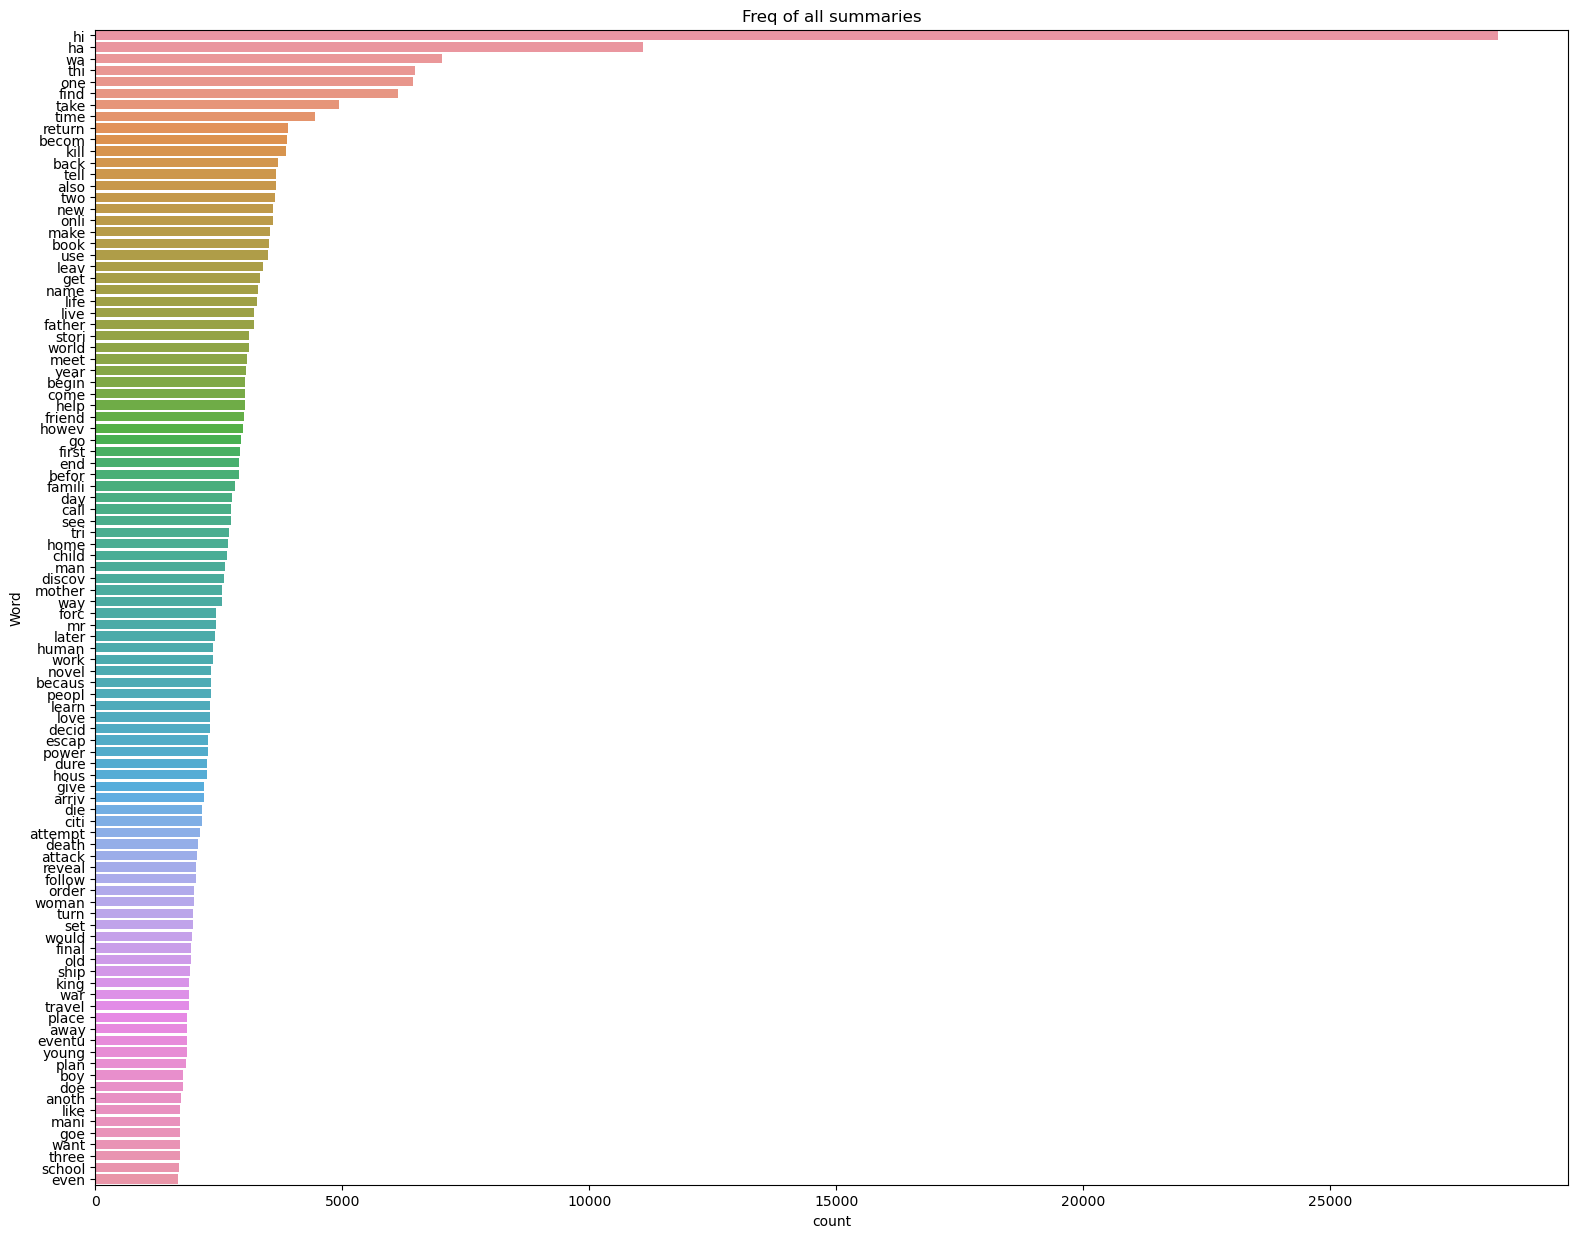

<module 'matplotlib.pyplot' from 'c:\\Users\\Alvaro\\miniconda3\\envs\\tf\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [34]:

#mostramos las 100 palabras mas comunes entre todos los libros
def plot_most_frequent_words(words, num_words=100, title=None, plt_show=None, size=(19,15)):
    # Create a frequency distribution of the words
    freq_dist = FreqDist(words)
    
    # Select the top 'num_words' most frequent words
    wordsdf = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())}) 
    top_words = wordsdf.sort_values(by='count', ascending=False).iloc[0:num_words]
    
    # Plotting
    plt.figure(figsize=size) 
    if title:
        plt.title(title)
    ax = sns.barplot(data=top_words, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    if plt_show:
        plt.show()
    return plt
    
plot_most_frequent_words(' '.join(list(data_cc.summary)).split(' '), num_words=100, title="Freq of all summaries", plt_show=True)

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_14792\2737546383.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plts = data_cc.groupby('genre').apply(lambda x: plot_most_frequent_words(' '.join(list(x.summary)).split(' '), num_words=20, title=x.name, plt_show=False, size=(5,7)))


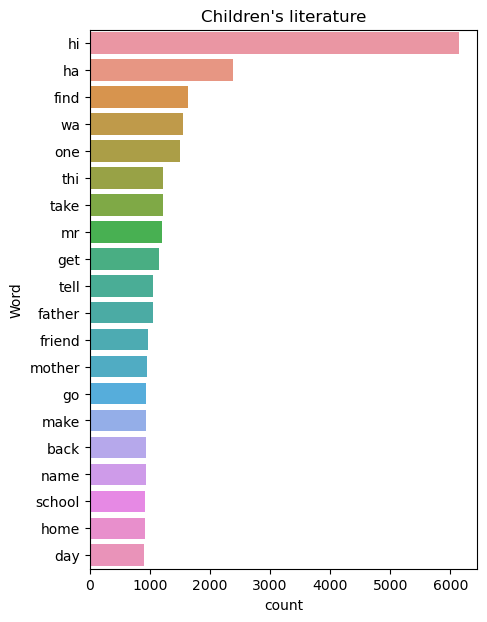

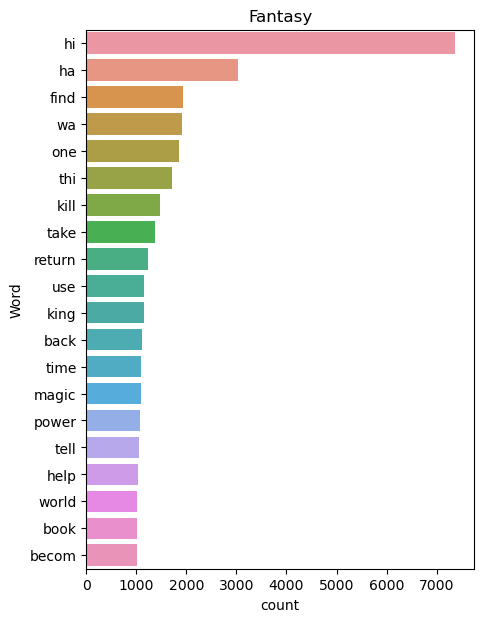

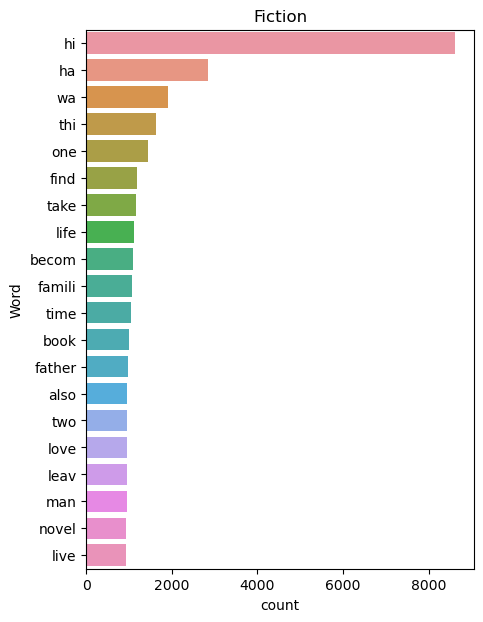

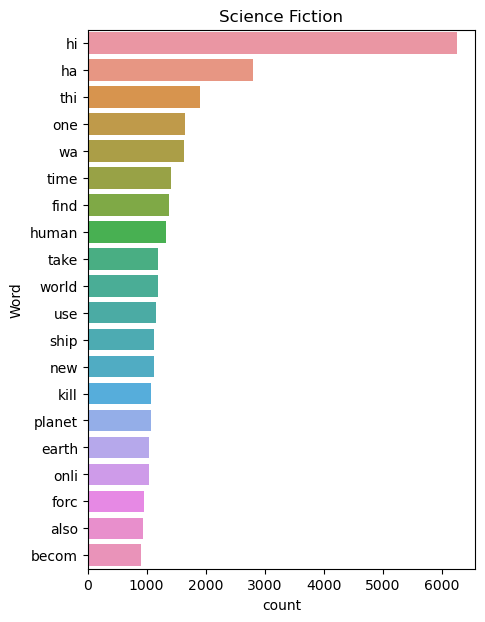

In [35]:
plts = data_cc.groupby('genre').apply(lambda x: plot_most_frequent_words(' '.join(list(x.summary)).split(' '), num_words=20, title=x.name, plt_show=False, size=(5,7)))

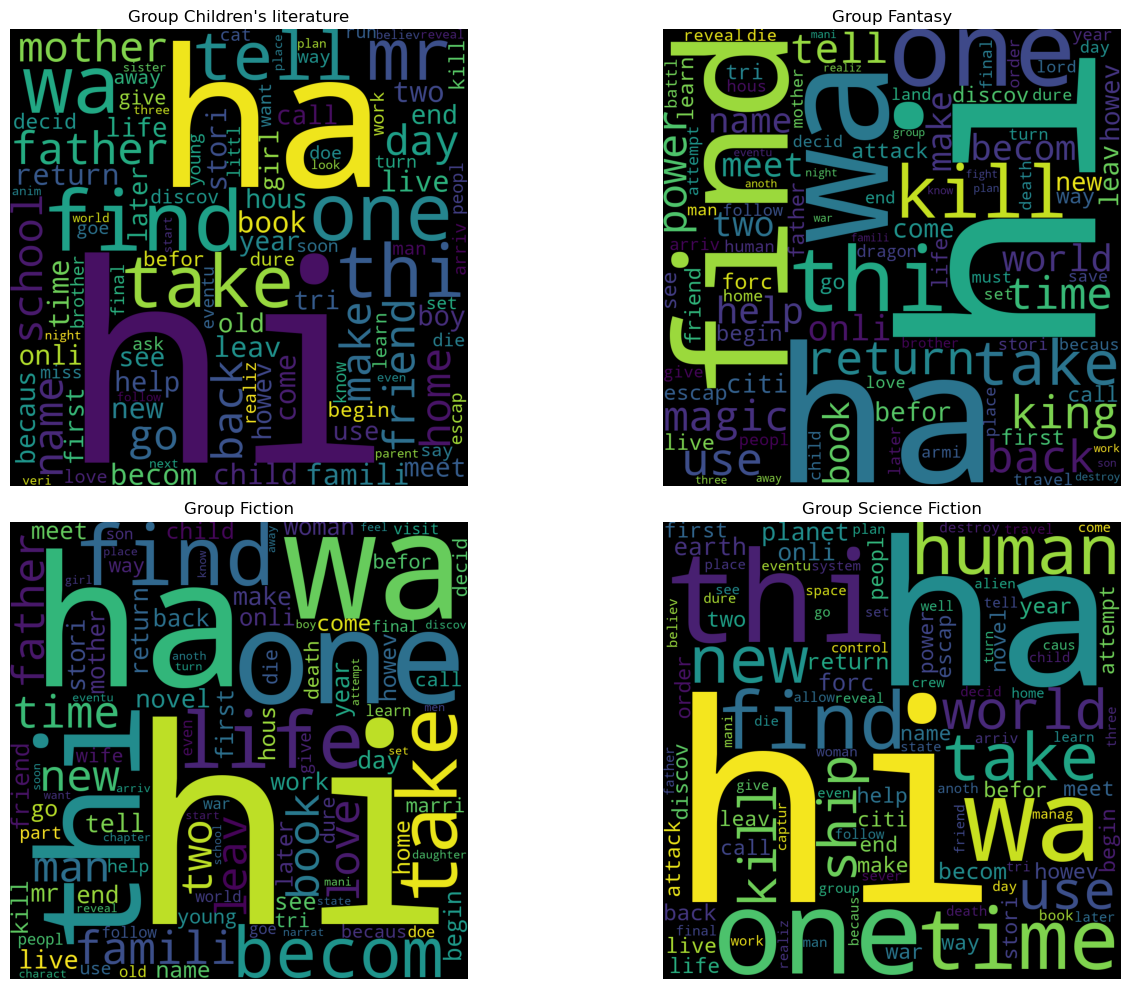

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for (genre,grp),ax in zip(data_cc.groupby('genre'),axes.flatten()):
    wc = wordcloud.WordCloud(
        width=1000, 
        height=1000, 
        max_words=100,
        collocations=False
    ).generate(text=(' '.join(grp.summary)))
    ax.imshow(wc)
    ax.set_title(f'Group {genre}')
    ax.axis("off");    

# Adjust layout
plt.tight_layout()
plt.show()
    

In [37]:
data_clean = data_cc.copy()

In [38]:
words_to_remove = ("hi", "ha", "thi", "wa", "one", "take", 'find', 'two')
def clean_summary(summary):
    #tokenizacion de frases
    sentences = get_sent_tokens(summary)
    words = get_word_tokens(sentences)
    words_cleaned = [w for w in words if w not in words_to_remove]
    
    return ' '.join(words_cleaned)

data_clean['summary'] = data_clean['summary'].apply(lambda x: clean_summary(x))

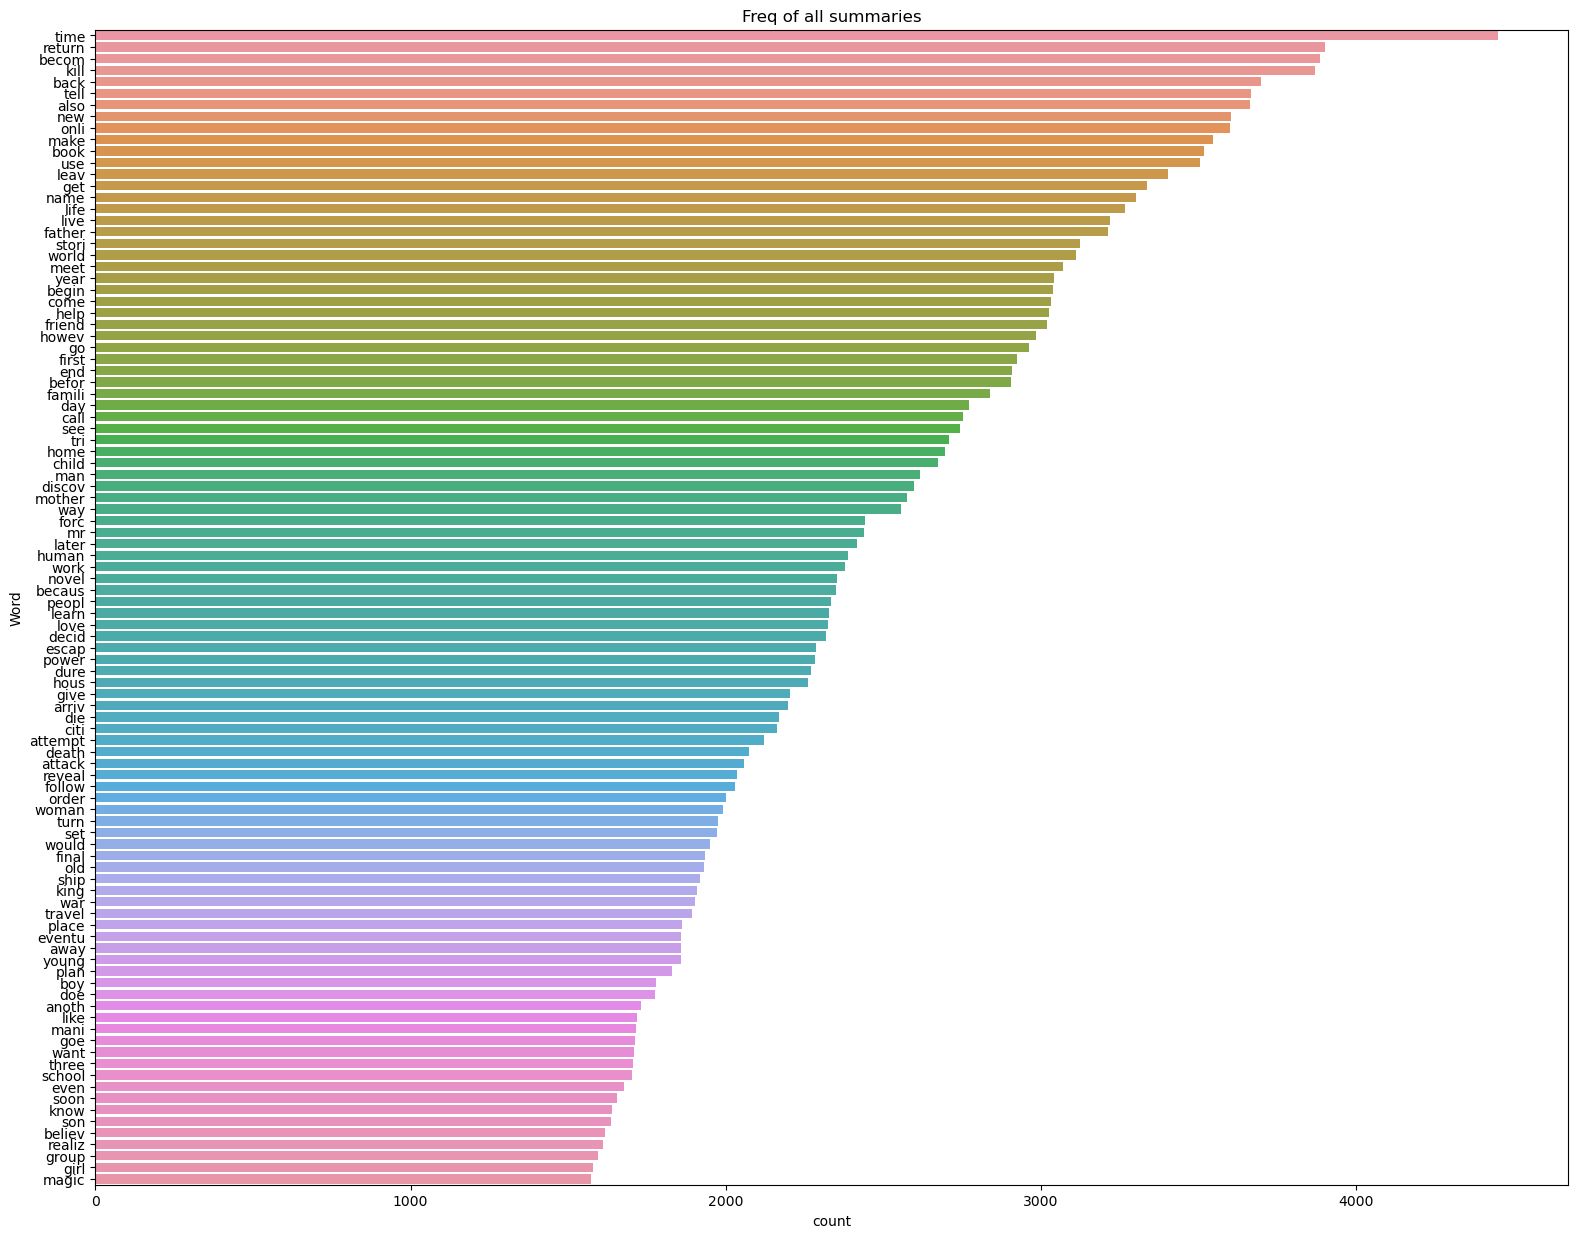

<module 'matplotlib.pyplot' from 'c:\\Users\\Alvaro\\miniconda3\\envs\\tf\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [39]:
plot_most_frequent_words(' '.join(list(data_clean.summary)).split(' '), num_words=100, title="Freq of all summaries", plt_show=True)

-----------------------------------------------
Children's literature ["Children's literature"] Axes(0.125,0.53;0.352273x0.35)
-----------------------------------------------
Fantasy ['Fantasy'] Axes(0.547727,0.53;0.352273x0.35)
-----------------------------------------------
Fiction ['Fiction'] Axes(0.125,0.11;0.352273x0.35)
-----------------------------------------------
Science Fiction ['Science Fiction'] Axes(0.547727,0.11;0.352273x0.35)


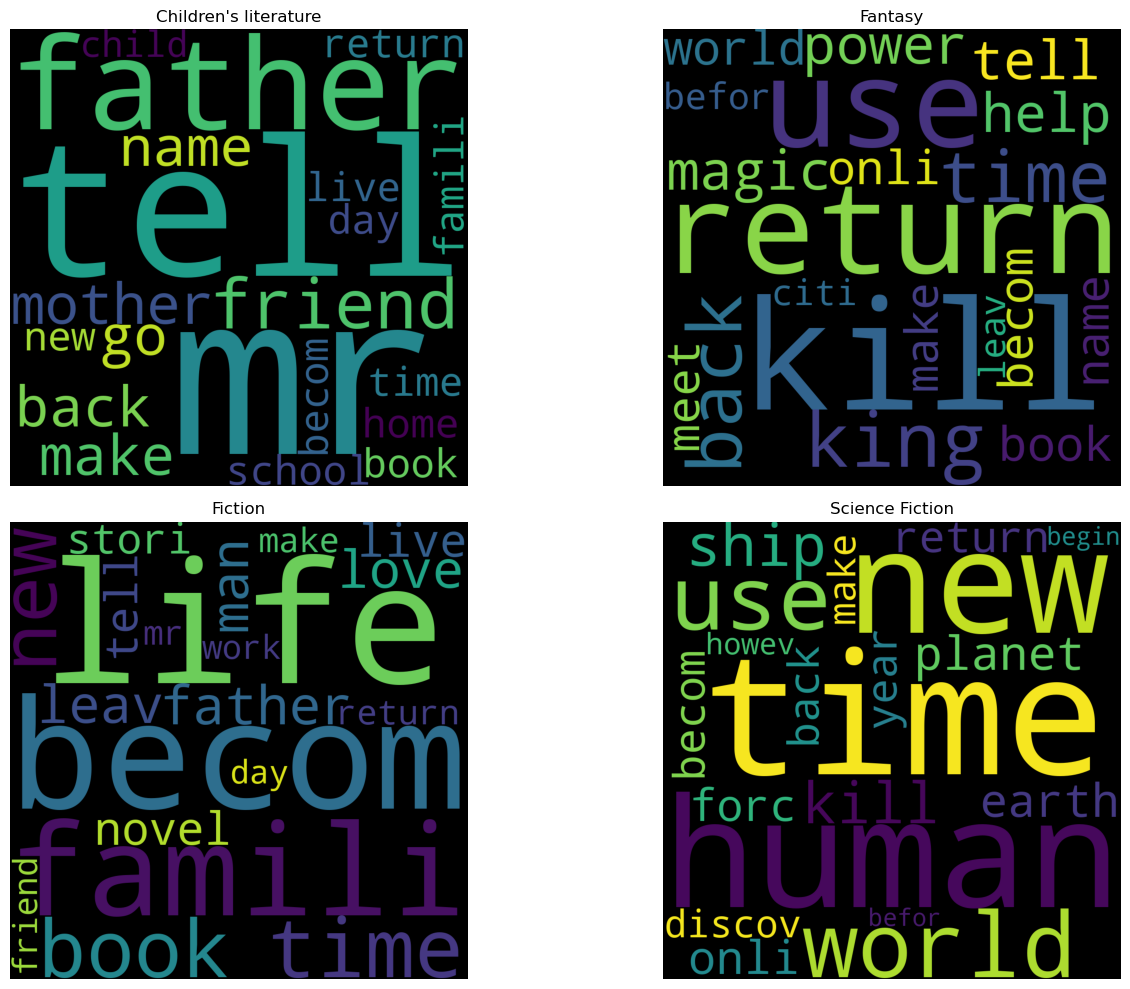

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for (genre,grp),ax in zip(data_clean.groupby('genre'),axes.flatten()):
    print('-----------------------------------------------')
    print(genre, grp.genre.unique(), ax)
    wc = wordcloud.WordCloud(
        width=1000, 
        height=1000, 
        max_words=20,
        collocations=False
    ).generate(text=(' '.join(grp.summary)))
    ax.imshow(wc)
    ax.set_title(f'{genre}')
    ax.axis("off");    

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_14792\3737436712.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plts = data_clean.groupby('genre').apply(lambda x: plot_most_frequent_words(' '.join(list(x.summary)).split(' '), num_words=20, title=x.name, plt_show=False, size=(5,7)))


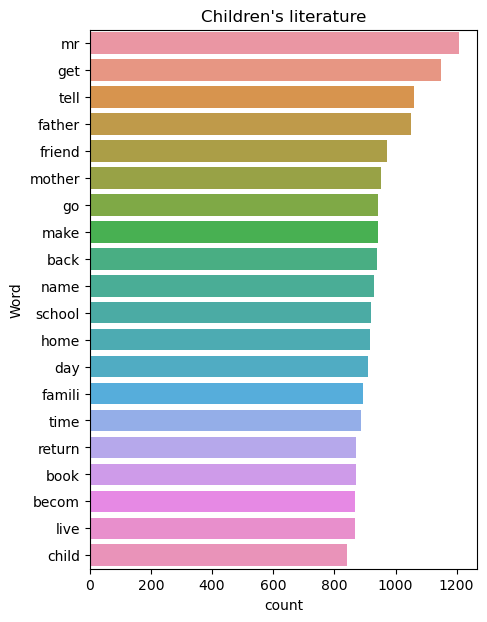

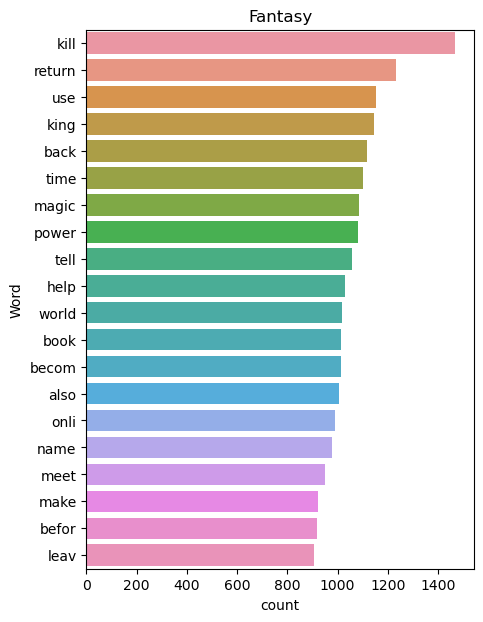

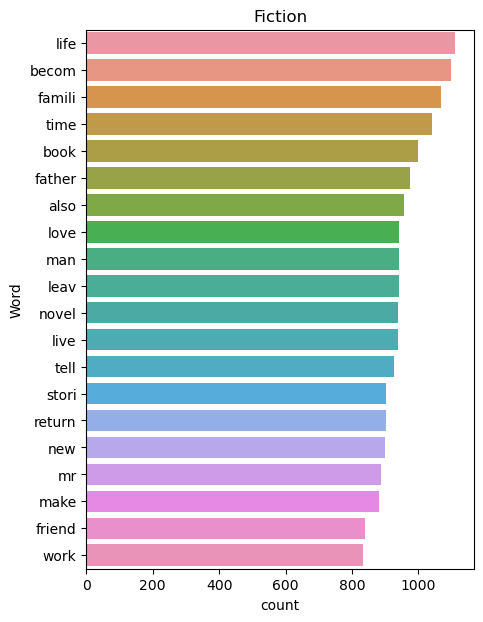

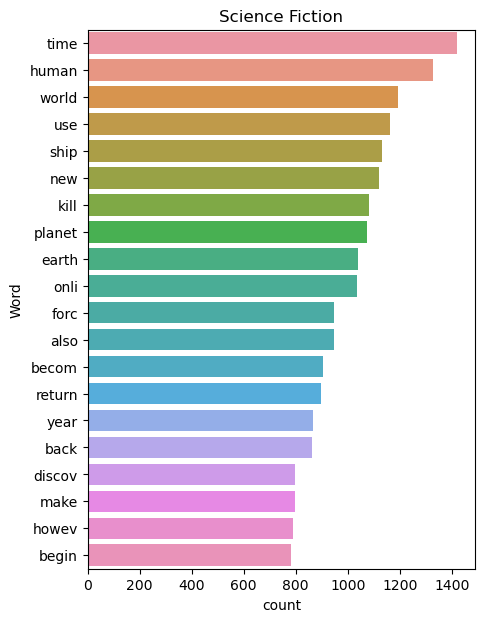

In [41]:
plts = data_clean.groupby('genre').apply(lambda x: plot_most_frequent_words(' '.join(list(x.summary)).split(' '), num_words=20, title=x.name, plt_show=False, size=(5,7)))

In [42]:
import pickle
with open("data_clean.pkl", "wb") as f:
    pickle.dump(data_clean, f)
    

# Features

In [43]:
import pickle
with open("data_ch1.pkl", "rb") as f:
    data_cc = pickle.load(f)
    


In [81]:
#usamos label encoder para codificar cada género
LE = LabelEncoder()
y=LE.fit_transform(data_cc['genre'])
dict(zip(LE.classes_,LE.transform(LE.classes_)))

{"Children's literature": 0, 'Fantasy': 1, 'Fiction': 2, 'Science Fiction': 3}

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_cc['summary'], y, test_size=0.2, random_state=557) 

In [46]:
#aplicamos tf-idf para poder pasarlo a los modelos
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer() # se ha visto que funciona mejor sin limtar el max_df ni el max_features

# Fit and transform the documents
tf_train  = tfidf_vectorizer.fit_transform(X_train)

# Convert the TF-IDF matrix to a pandas DataFrame
tf_test = tfidf_vectorizer.transform(X_test)



In [47]:
def apply_tfidf(string):
    tfidf_vectorizer = TfidfVectorizer() # se ha visto que funciona mejor sin limtar el max_df ni el max_features
    # Fit and transform the documents
    tf_train  = tfidf_vectorizer.fit_transform(X_train)
    # Convert the TF-IDF matrix to a pandas DataFrame
    tf_test = tfidf_vectorizer.transform(string)
    return tf_test
    

# Modelos

## Random Forest

In [49]:
param_grid = {
    'n_estimators': [100, 300, 500, 1000, 1500],
    'max_depth': [10,20,50],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2','sqrt']
}
rf = RandomForestClassifier()

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=2,
    n_jobs=-1,
    verbose=True
)
# fit model on train data.
grid.fit(tf_train, y_train)

print("Best parameters found: ", grid.best_params_)
print("Best score found: ", grid.best_score_)
rf = grid.best_estimator_

Fitting 2 folds for each of 270 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1500}
Best score found:  0.6847399411187438


In [50]:
#guardamos los resultados para poder recuperarlo sin ejecutar todo
import pickle
with open("rf_grid.pkl", 'wb') as f:
    pickle.dump(grid, f)

In [51]:
import pickle
with open("rf_grid.pkl", 'rb') as f:
    grid = pickle.load(f)

In [52]:
grid

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500, 1000, 1500]},
             verbose=True)

In [53]:
grid.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1500}

In [54]:
# make predictions for validation set.
y_pred = rf.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred) )

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred, target_names=LE.classes_))

Accuracy Score : 0.7049019607843138
Report : 
                       precision    recall  f1-score   support

Children's literature       0.61      0.69      0.65       235
              Fantasy       0.69      0.65      0.67       260
              Fiction       0.71      0.73      0.72       260
      Science Fiction       0.81      0.74      0.78       265

             accuracy                           0.70      1020
            macro avg       0.71      0.70      0.70      1020
         weighted avg       0.71      0.70      0.71      1020



## Logistic Regression

In [55]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data.
clf.fit(tf_train, y_train)

# make predictions for validation set.
y_pred_lr = clf.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred_lr))

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred_lr, target_names=LE.classes_))
#.7916666666

Accuracy Score : 0.7107843137254902
Report : 
                       precision    recall  f1-score   support

Children's literature       0.63      0.66      0.64       235
              Fantasy       0.71      0.68      0.70       260
              Fiction       0.70      0.75      0.72       260
      Science Fiction       0.80      0.74      0.77       265

             accuracy                           0.71      1020
            macro avg       0.71      0.71      0.71      1020
         weighted avg       0.71      0.71      0.71      1020



In [56]:
tf_test

<1020x50012 sparse matrix of type '<class 'numpy.float64'>'
	with 162745 stored elements in Compressed Sparse Row format>

In [57]:
import numpy as np
print(clf.predict(apply_tfidf(["space time is flexible when dealing with aliens in space"]))) #tiene sentido que sea ciencia ficción
print(clf.predict(apply_tfidf(["The detective wasn't sure if the crime would be solvable"]))) #tiene sentido que sea crimen

[3]
[2]


## SVM

In [58]:
param_grid = {
    "C": CategoricalDistribution([.1, 1, 10, 100, 1000]),
    "kernel": CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": IntDistribution(0, 5),
    "gamma": CategoricalDistribution(["auto","scale"]),
    "shrinking": CategoricalDistribution([True, False]),
    "probability": CategoricalDistribution([True, False])
}
svc = SVC()

rs = OptunaSearchCV(
    estimator=svc,
    param_distributions=param_grid,
    n_trials=50,
    timeout=15*60,
    cv=5,
    random_state=99,
    n_jobs=-1,
    verbose=False
)
# fit model on train data.
rs.fit(tf_train, y_train)


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_14792\847742533.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rs = OptunaSearchCV(
[I 2024-05-04 17:48:13,950] A new study created in memory with name: no-name-1ba9d932-1fbd-4a6a-9e68-ec4407e227c1
[I 2024-05-04 17:50:55,978] Trial 1 finished with value: 0.25490677252496097 and parameters: {'C': 0.1, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'shrinking': True, 'probability': False}. Best is trial 1 with value: 0.25490677252496097.
[I 2024-05-04 17:50:57,989] Trial 3 finished with value: 0.25490677252496097 and parameters: {'C': 10, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'shrinking': True, 'probability': False}. Best is trial 1 with value: 0.25490677252496097.
[I 2024-05-04 17:50:58,246] Trial 0 finished with value: 0.25490677252496097 and parameters: {'C': 1, 'kernel': 'sigmoid', 'degree': 4, 'gamma': 'auto', 'shrinking': True, 'probability': False}

OptunaSearchCV(cv=5, estimator=SVC(), n_jobs=-1, n_trials=50,
               param_distributions={'C': CategoricalDistribution(choices=(0.1, 1, 10, 100, 1000)),
                                    'degree': IntDistribution(high=5, log=False, low=0, step=1),
                                    'gamma': CategoricalDistribution(choices=('auto', 'scale')),
                                    'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')),
                                    'probability': CategoricalDistribution(choices=(True, False)),
                                    'shrinking': CategoricalDistribution(choices=(True, False))},
               random_state=99, timeout=900, verbose=False)

In [59]:
# len(rs.trials_)

In [60]:
# guardamos los resultados para poder recuperarlo sin ejecutar todo
import pickle
with open("svc_grid.pkl", 'wb') as f:
    pickle.dump(rs, f)

In [61]:
import pickle
with open("svc_grid.pkl", 'rb') as f:
    rs = pickle.load(f)

In [62]:
print("Best parameters found: ", rs.best_params_)
print("Best score found: ", rs.best_score_)
svc = rs.best_estimator_


Best parameters found:  {'C': 1, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'shrinking': False, 'probability': True}
Best score found:  0.7225204498977505


In [63]:
# make predictions for validation set.
y_pred = svc.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred) )

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred, target_names=LE.classes_))

Accuracy Score : 0.7225490196078431
Report : 
                       precision    recall  f1-score   support

Children's literature       0.62      0.66      0.64       235
              Fantasy       0.71      0.72      0.72       260
              Fiction       0.72      0.75      0.73       260
      Science Fiction       0.84      0.76      0.80       265

             accuracy                           0.72      1020
            macro avg       0.72      0.72      0.72      1020
         weighted avg       0.73      0.72      0.72      1020



## RNNs

### Bag of words

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (4076, 1880321)
BOW_cv_test: (1020, 1880321)


### Preprocessing for adecuate input

In [65]:
df_lstm = data_cc[['genre','summary']]
df_lstm

,genre,summary
3000,Children's literature,old major old boar manor farm call anim farm m...
3004,Children's literature,ged young boy gont one larger island north arc...
3013,Children's literature,first salli alonso quijano protagonist novel r...
3017,Children's literature,one day gregor samsa travel salesman wake find...
3025,Children's literature,stori begin fiction st petersburg missouri sho...
...,...,...
11087,Science Fiction,author friend jason gridley experi new radio f...
5626,Science Fiction,begin stori jimmi mother father murder best fr...
3607,Science Fiction,messag carri pointless albatross arriv lord ve...
8814,Science Fiction,event weyr pern dolphin pern ski pern thread l...


In [66]:
summ_lengths = [len(get_word_tokens(get_sent_tokens(elem))) for elem in df_lstm.summary]

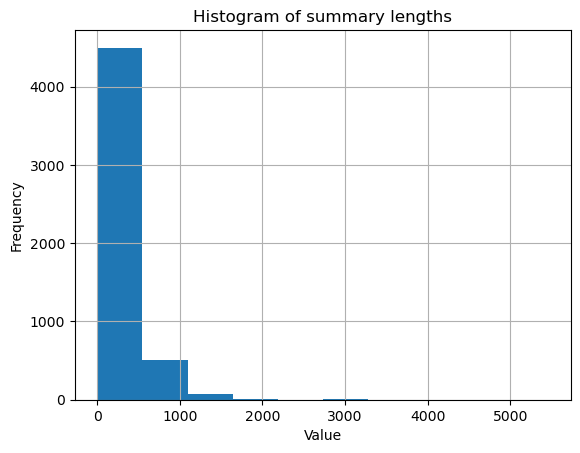

In [67]:
import matplotlib.pyplot as plt
# Plot histogram
plt.hist(summ_lengths)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of summary lengths')
plt.grid(True)
plt.show()


In [68]:
max([len(get_word_tokens(get_sent_tokens(elem))) for elem in df_lstm.summary])

5458

### LabelEncoder (en pruebas)

### Frequency counting (like imbd dataset)

In [69]:
df_lstm = data_cc[['genre','summary']]
df_lstm

,genre,summary
3000,Children's literature,old major old boar manor farm call anim farm m...
3004,Children's literature,ged young boy gont one larger island north arc...
3013,Children's literature,first salli alonso quijano protagonist novel r...
3017,Children's literature,one day gregor samsa travel salesman wake find...
3025,Children's literature,stori begin fiction st petersburg missouri sho...
...,...,...
11087,Science Fiction,author friend jason gridley experi new radio f...
5626,Science Fiction,begin stori jimmi mother father murder best fr...
3607,Science Fiction,messag carri pointless albatross arriv lord ve...
8814,Science Fiction,event weyr pern dolphin pern ski pern thread l...


In [70]:
max_features = 10000
wc = get_word_counter(df_lstm.summary, max_features=max_features)
wc

{'hi': 28390,
 'ha': 11080,
 'wa': 7016,
 'thi': 6482,
 'one': 6437,
 'find': 6132,
 'take': 4938,
 'time': 4448,
 'return': 3901,
 'becom': 3884,
 'kill': 3870,
 'back': 3697,
 'tell': 3665,
 'also': 3662,
 'two': 3640,
 'new': 3602,
 'onli': 3598,
 'make': 3544,
 'book': 3518,
 'use': 3504,
 'leav': 3403,
 'get': 3336,
 'name': 3301,
 'life': 3265,
 'live': 3218,
 'father': 3211,
 'stori': 3122,
 'world': 3112,
 'meet': 3069,
 'year': 3042,
 'begin': 3039,
 'come': 3030,
 'help': 3024,
 'friend': 3020,
 'howev': 2985,
 'go': 2960,
 'first': 2922,
 'end': 2909,
 'befor': 2903,
 'famili': 2837,
 'day': 2771,
 'call': 2751,
 'see': 2744,
 'tri': 2709,
 'home': 2696,
 'child': 2672,
 'man': 2617,
 'discov': 2597,
 'mother': 2574,
 'way': 2557,
 'forc': 2442,
 'mr': 2438,
 'later': 2416,
 'human': 2387,
 'work': 2377,
 'novel': 2352,
 'becaus': 2349,
 'peopl': 2335,
 'learn': 2327,
 'love': 2323,
 'decid': 2319,
 'escap': 2287,
 'power': 2284,
 'dure': 2269,
 'hous': 2260,
 'give': 2205,


In [71]:
len(wc)

10000

In [72]:
df_lstm['summary'] = df_lstm.summary.apply(tokenize_summary)

In [73]:
df_lstm['summary'] = df_lstm.summary.apply(lambda row: filter_and_tokenize_words(row, wc))

In [74]:
df_lstm

,genre,summary
3000,Children's literature,"[1930, 385, 1930, 28, 49, 492, 2751, 798, 492,..."
3004,Children's literature,"[43, 1858, 1780, 6437, 124, 973, 418, 12, 2839..."
3013,Children's literature,"[2922, 174, 363, 2352, 180, 691, 133, 644, 48,..."
3017,Children's literature,"[6437, 2771, 71, 1894, 32, 455, 6132, 375, 99,..."
3025,Children's literature,"[3122, 3039, 320, 162, 15, 99, 27, 583, 194, 2..."
...,...,...
11087,Science Fiction,"[528, 3020, 152, 784, 3602, 130, 66, 154, 194,..."
5626,Science Fiction,"[3039, 3122, 121, 2574, 3211, 874, 636, 3020, ..."
3607,Science Fiction,"[426, 668, 2196, 1041, 19, 571, 426, 951, 246,..."
8814,Science Fiction,"[1001, 24, 58, 24, 80, 24, 72, 327, 355, 1206,..."


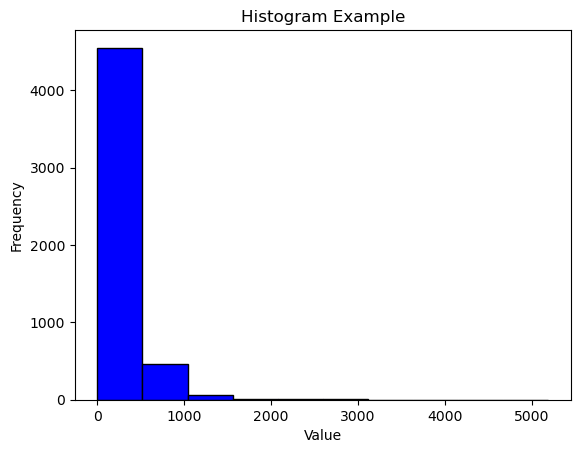

In [75]:
lengths = [len(e) for e in df_lstm.summary]

import matplotlib.pyplot as plt

# Sample data

# Plotting the histogram
plt.hist(lengths, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Displaying the plot
plt.show()

In [79]:
print(len(y))
print(len(df_lstm.summary))

5096
5096


In [85]:
maxlen = 1000
X = df_lstm.summary
y = to_categorical(y)
X = pad_sequences(X, maxlen=maxlen)

In [103]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(4, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X, y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    )

Epoch 1/50
128/128 [==============================] - 7s 40ms/step - loss: 0.5359 - acc: 0.3265 - val_loss: 0.9621 - val_acc: 0.0000e+00
Epoch 2/50
128/128 [==============================] - 4s 33ms/step - loss: 0.5116 - acc: 0.4190 - val_loss: 0.8605 - val_acc: 0.0000e+00
Epoch 3/50
128/128 [==============================] - 4s 33ms/step - loss: 0.4643 - acc: 0.5594 - val_loss: 0.9193 - val_acc: 0.0000e+00
Epoch 4/50
128/128 [==============================] - 4s 33ms/step - loss: 0.4258 - acc: 0.6053 - val_loss: 0.9227 - val_acc: 0.0000e+00
Epoch 5/50
128/128 [==============================] - 4s 32ms/step - loss: 0.3977 - acc: 0.6418 - val_loss: 0.9805 - val_acc: 0.0000e+00
Epoch 6/50
128/128 [==============================] - 4s 33ms/step - loss: 0.3802 - acc: 0.6661 - val_loss: 0.8961 - val_acc: 0.0000e+00
Epoch 7/50
128/128 [==============================] - 4s 32ms/step - loss: 0.3607 - acc: 0.6943 - val_loss: 0.8476 - val_acc: 0.0000e+00
Epoch 8/50
128/128 [=====================

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_13 (Dense)            (None, 4)                 132       
                                                                 
Total params: 328,452
Trainable params: 328,452
Non-trainable params: 0
_________________________________________________________________


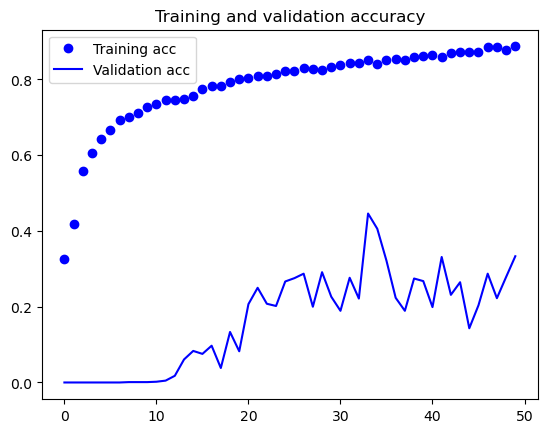

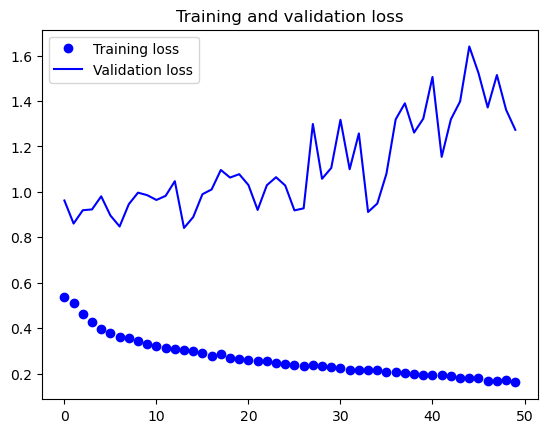

In [104]:
model.summary()
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file="model.png")
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
from sklearn.metrics import classification_report

# Assuming your neural network model is named 'model' and you have test data 'X_test' and corresponding labels 'y_test'
predicted_labels = model.predict(X_test)

# Assuming your labels are one-hot encoded, convert them back to categorical labels
predicted_classes = np.argmax(predicted_labels, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=LE.classes_)
print( 'Accuracy Score :',accuracy_score(y_test,to_categorical(predicted_classes)))
print(report)

32/32 [==============================] - 1s 25ms/step
Accuracy Score : 0.7774509803921569
                       precision    recall  f1-score   support

Children's literature       0.81      0.87      0.84       235
              Fantasy       0.72      0.85      0.78       260
              Fiction       0.75      0.95      0.84       260
      Science Fiction       0.90      0.46      0.61       265

             accuracy                           0.78      1020
            macro avg       0.80      0.78      0.77      1020
         weighted avg       0.80      0.78      0.76      1020



In [91]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # monitor the validation loss
    patience=5,          # stop after no improvement for 5 epochs
    restore_best_weights=True  # restore the best model weights
)


def call_model(units, activation, dropout, lr, optimizer, layers):
    model = Sequential()
    model.add(Dense(units=units, input_dim=1000, activation=activation))
    model.add(Dropout(rate=dropout))
    for _ in range(layers-1): #ya hemos añadido una
        model.add(Dense(units=units, activation=activation))
        model.add(Dropout(rate=dropout))
    model.add(Dense(4, activation="softmax"))
    model.compile(
        optimizer=build_optimizer(optimizer, lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=256, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Float("dropout", min_value=0, max_value=.8, step=.2)
    optimizer = hp.Choice("optimizer", ["adam", "sgd"])
    layers = hp.Int("num_layers", min_value=2, max_value=8, step=2)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_model(
        units=units, activation=activation, dropout=dropout, lr=lr, optimizer=optimizer, layers=layers
    )
    return model

# def run_model(config=None):
#     with wandb.init(config=config):
#         config = wandb.config
#         print(config)
#         model = call_model(config.units, config.activation, config.dropout, config.lr, config.optimizer, config.layers)
#         history = model.fit(X, y, epochs=config.epochs, callbacks=[early_stopping], batch_size=config.batch_size, validation_split=.2)
#         print(history)
#         # for epoch in range(config.epochs):
#         #     wandb.log({
#         #         "train_acc": history["train_accuracy"][epoch],
#         #         "train_loss": history["train_loss"][epoch],
#         #         "valid_acc": history["valid_accuracy"][epoch],
#         #         "valid_loss": history["valid_loss"][epoch]
#         #     },
#         #         step=epoch+1         
#         #     )
#     model.save(f'resnet-{config.epoch}')



build_model(keras_tuner.HyperParameters())

c:\Users\Alvaro\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=557)

In [93]:
# import wandb


# sweep_configuration = {
#     "name": "sweep",
#     "method": "grid",
#     "metric": {"goal": "minimize", "name": "valid_loss"},
#     "parameters": {
#         "learning_rate": {"value": 1e-4},        
#         "batch_size": {"value": 32},
#         "epochs": {"value": 20},
#         "optimizer": {"value": "adam"},
#         "model": {"value": "resnet50"},
#         "weights": {"value": "DEFAULT"},
#         "criterion": {"value": "CrossEntropyLoss"},
#         "unfrozen_layers": {"value": 5},
#     },
# }

# sweep_id = wandb.sweep(sweep_configuration, project="cnn_param_selection")
# wandb.agent(sweep_id, run_model)
# wandb.finish()

In [94]:
from keras_tuner.tuners import BayesianOptimization
tuner = BayesianOptimization (
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=600,
    executions_per_trial=1,
    directory='search4classes',
    project_name='book4predict',
    overwrite=True
     # add the early stopping callback
)


In [95]:

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
             )

Trial 600 Complete [00h 00m 14s]
val_accuracy: 0.2666666805744171

Best val_accuracy So Far: 0.30588236451148987
Total elapsed time: 02h 55m 49s


In [96]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

c:\Users\Alvaro\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               6

In [97]:
import numpy as np
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(1)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), 
                    # callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
                    )

Epoch 1/50
128/128 [==============================] - 2s 10ms/step - loss: 1.4121 - accuracy: 0.2402 - val_loss: 1.4048 - val_accuracy: 0.2314
Epoch 2/50
128/128 [==============================] - 1s 9ms/step - loss: 1.3840 - accuracy: 0.2826 - val_loss: 1.4045 - val_accuracy: 0.2422
Epoch 3/50
128/128 [==============================] - 1s 9ms/step - loss: 1.3804 - accuracy: 0.2861 - val_loss: 1.4031 - val_accuracy: 0.2578
Epoch 4/50
128/128 [==============================] - 1s 8ms/step - loss: 1.3749 - accuracy: 0.3069 - val_loss: 1.4016 - val_accuracy: 0.2529
Epoch 5/50
128/128 [==============================] - 1s 8ms/step - loss: 1.3733 - accuracy: 0.2983 - val_loss: 1.3999 - val_accuracy: 0.2657
Epoch 6/50
128/128 [==============================] - 1s 9ms/step - loss: 1.3672 - accuracy: 0.3207 - val_loss: 1.4041 - val_accuracy: 0.2608
Epoch 7/50
128/128 [==============================] - 1s 9ms/step - loss: 1.3641 - accuracy: 0.3116 - val_loss: 1.4099 - val_accuracy: 0.2500
Epoch

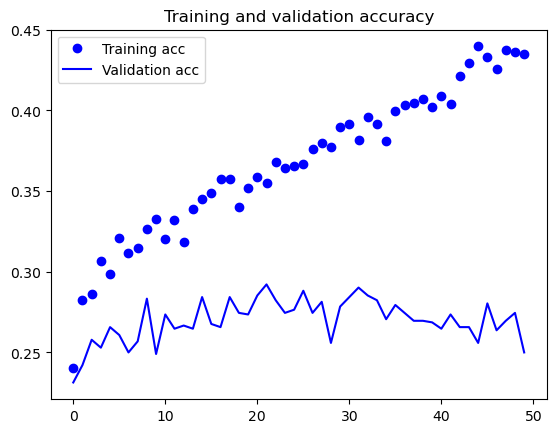

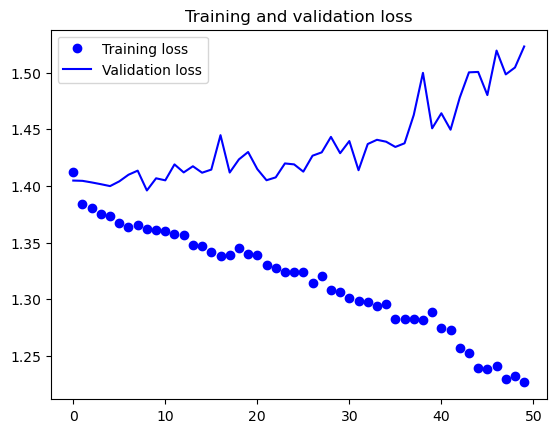

In [98]:
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file="model.png")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [99]:
import pickle 

with open("dense.pkl", "wb") as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://d3b43a54-1b60-4993-95eb-0e4f4e0946f7/assets


In [100]:
from sklearn.metrics import classification_report

# Assuming your neural network model is named 'model' and you have test data 'X_test' and corresponding labels 'y_test'
predicted_labels = model.predict(X_test)

# Assuming your labels are one-hot encoded, convert them back to categorical labels
predicted_classes = np.argmax(predicted_labels, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=LE.classes_)
print(report)

32/32 [==============================] - 0s 2ms/step
                       precision    recall  f1-score   support

Children's literature       0.17      0.04      0.07       235
              Fantasy       0.20      0.11      0.14       260
              Fiction       0.27      0.17      0.21       260
      Science Fiction       0.26      0.65      0.37       265

             accuracy                           0.25      1020
            macro avg       0.23      0.24      0.20      1020
         weighted avg       0.23      0.25      0.20      1020

